In [35]:
import glob
import pathlib

import celltypist
import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from celltypist import models

%matplotlib inline
from matplotlib import pyplot as plt

params = {
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 8,
    "ytick.labelsize": 10,
    "font.family": "Arial",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 100,
}

tissue = "LN"
mpl.rcParams.update(params)
sns.set_style("ticks")
sns.set_context(context="paper")
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0,
    "transparent": True,
}
mpl.rc("savefig", dpi=300)
output_dir = "figures/QCandAnnotation/{}".format(tissue)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(
    format="pdf",
    transparent=True,
)


def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None


pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%run _helper.py

In [37]:
def merge_vdj(obs_df, vdj_df):
    vdj_df = vdj_df.reset_index()
    # prepare merge
    vdj_df["cb_suid"] = vdj_df["cb"] + "_" + vdj_df["sample_uid"]
    # remove duplicates
    vdj_df = vdj_df[~vdj_df["cb_suid"].duplicated()]
    obs_df["cb"] = pd.Series(obs_df.index).str.split("-", expand=True)[0].values
    obs_df["cb_suid"] = (
        obs_df["cb"].astype(str) + "_" + obs_df["sample_uid"].astype(str)
    )
    obs_df.set_index("cb_suid", inplace=True)
    vdj_df.set_index("cb_suid", inplace=True)

    # merge
    obs_df = pd.merge(
        obs_df,
        vdj_df,
        left_index=True,
        right_index=True,
        how="left",
        suffixes=[None, "_vdj"],
    )
    return obs_df

In [38]:
vdj_df = pd.read_table(
    "/home/michaelswift/repos/shared_data/tbd_share/integrated_no_contaminants_with_flags_and_ambient_sources.tsv.gz",
    index_col=0,
)

<ipython-input-38-383b929b6acc>:1: DtypeWarning: Columns (2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,54,56,58,59,60,63,73,74,75,76,77,78,79,80,81,82,83,85,95,100,101,102,103,114,119) have mixed types. Specify dtype option on import or set low_memory=False.
  vdj_df = pd.read_table(


In [39]:
obs_df = pd.read_table("gex_labels.tsv.gz", index_col=0)

In [40]:
obs_df = merge_vdj(obs_df, vdj_df)

In [41]:
import gc
del vdj_df
gc.collect()

18

In [42]:
from numpy.random import seed


def df_generate_node_dict(frame, singletons=False):
    """ Generates a node property dictionary for downstream graph-tool plotting
        Args:
            frame (pd.Dataframe) with the following columns:
                - lineage_id (mandatory)
                - node_color (optional)
                - node_shape (optional)
                - node_size (optional)
                - node_stroke (optional)
            singletons (bool): whether to include cells that do not form
                multi-member clonal families
        Returns:
            dict: nested as follows: {node_id: {'property1': 'value1', ...}}
    """
    frame = frame.copy()

    # use some defaults if property columns are missing
    req_key_defaults = {'node_color': 'blue',
                        'node_shape': 'circle',
                        'node_size': 3,
                        'node_stroke': 0.01}
    for key, default in req_key_defaults.items():
        if key not in frame.columns:
            frame[key] = default  # add column to dataframe

    node_props = {}
    node_id = 0
    # rootless doesn't work right now bc the graph doesn't get connected
    root = True
    for lin, g in frame.groupby('lineage_id'):
        if g.shape[0] > 1 or singletons:
            if g.shape[0] > 1:
                if root:
                # add a germline to root all cells in a lineage
                    gid = node_id
                    node_props[gid] = {'color': 'k',
                                       'ancestor': None,
                                       'size': frame['node_size'].min(),
                                       'shape': 'circle',
                                       'stroke': 0}
                    node_id += 1
                else:
                    gid = None
            else:
                # no germline root for a singleton
                gid = None

            # add cell(s) with properties
            for _, row in g.iterrows():
                node_props[node_id] = {'ancestor': gid,
                                       'color': row['node_color'],
                                       'shape': row['node_shape'],
                                       'size': row['node_size'],
                                       'stroke': row['node_stroke']
                                       }
                node_id += 1

    return node_props


def draw_gviz(node_dict, size_multiple=50, random_seed=42, layout = 'patchwork', **kwargs):
    """ Draw clonal network using graph-tool
    More information: graphtool edge / vertex parameters and examples:
        https://graph-tool.skewed.de/static/doc/draw.html#graph_tool.draw.graph_draw
        http://ryancompton.net/2014/10/05/graph-tools-visualization-is-pretty-good/
    Args:
        node_dict (dict): nested dictionary of node properties
            Generate this using df_generate_node_dict()
        size_multiple (int): scaling factor for node size (for convenience)
        **kwargs: keyword arguments passed to gt.graph-draw()
            e.g. output='file.pdf', layout='neato', output_size=(300,300)
    """
    import graph_tool.all as gt

    g = gt.Graph()
    vsizes = g.new_vertex_property("int")
    vcolors = g.new_vertex_property('string')
    vshapes = g.new_vertex_property('string')
    vpenwidth = g.new_vertex_property("float")  # stroke

    for node_id, node_props in node_dict.items():
        g.add_vertex()

        vshapes[g.vertex(node_id)] = node_props['shape']
        vcolors[g.vertex(node_id)] = node_props['color']
        vsizes[g.vertex(node_id)] = node_props['size']*size_multiple
        vpenwidth[g.vertex(node_id)] = node_props['stroke']

        # add edge to ancestor
        if node_props['ancestor'] is not None:
            g.add_edge(node_props['ancestor'], node_id)

    # seeds enable graph reproduction
    seed(random_seed)
    gt.seed_rng(random_seed)

    gt.graph_draw(g,
                  vertex_size=vsizes,
                  vertex_fill_color=vcolors,
                  vertex_shape=vshapes,
                  vertex_pen_width=vpenwidth,
                  vertex_color='k',  # stroke color
                  bg_color=[1, 1, 1, 1],  # white
                  edge_end_marker='none',
                  **kwargs)

In [43]:
obs_df = obs_df[obs_df.probable_hq_single_b_cell == True]

In [44]:
def df_prep_for_node_dict(df, var, var_dictionary, parameter):
    "color_var is a column of the df: e.g. c_call, celltype"
    "color_var_palette is a dictionary which maps vars to colors"
    temp_df = df.copy()
    temp_df.loc[:,"node_{}".format(parameter)] = temp_df[var].map(lambda x: var_dictionary[0].get(x, var_dictionary[1]))
    return temp_df

In [45]:
df = df_prep_for_node_dict(obs_df, var = 'c_call', var_dictionary = ({"IGHM":"green", "IGHD":"green"}, "grey"), parameter='color')
df = df_prep_for_node_dict(df, var = 'tissue', var_dictionary = ({"LN":"hexagon", "PB":"square", "BM": "triangle", "SP":'circle'}, "octagon"), parameter='shape')

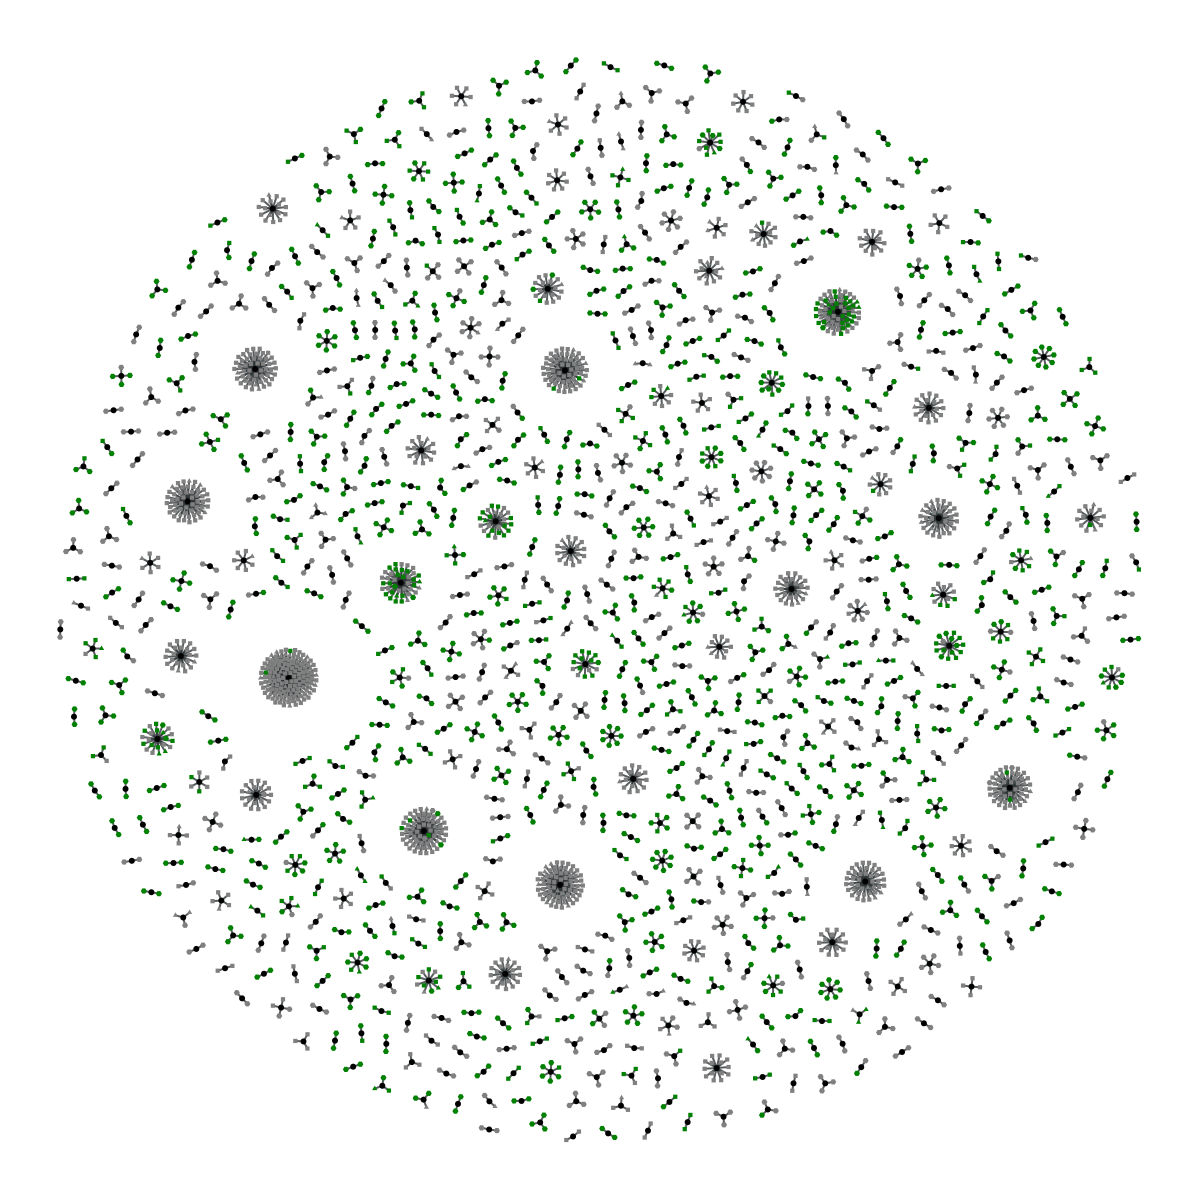

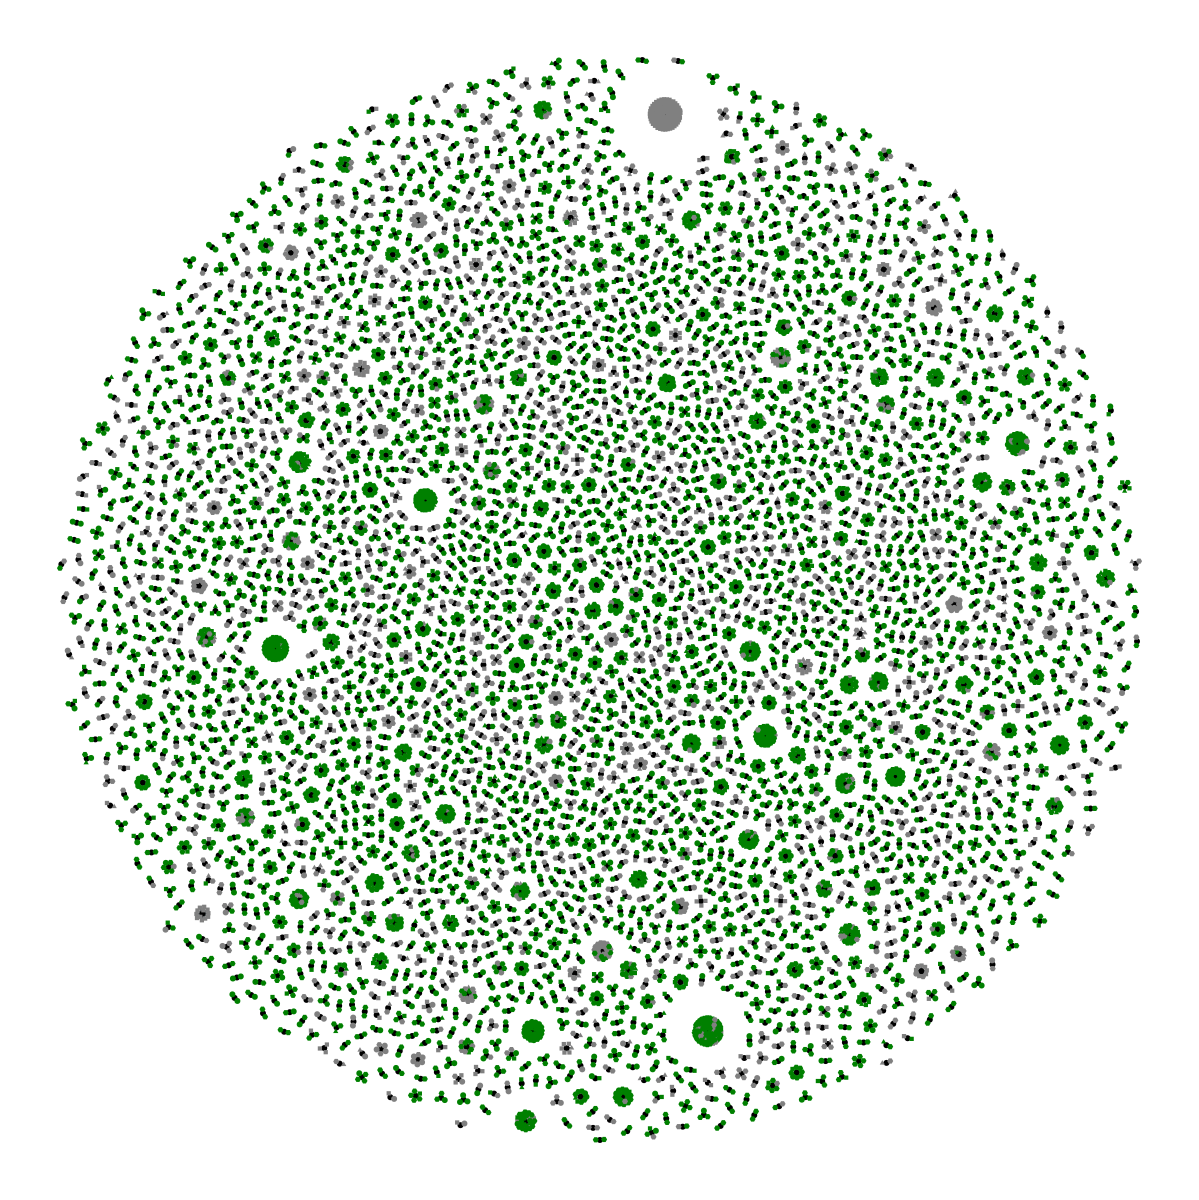

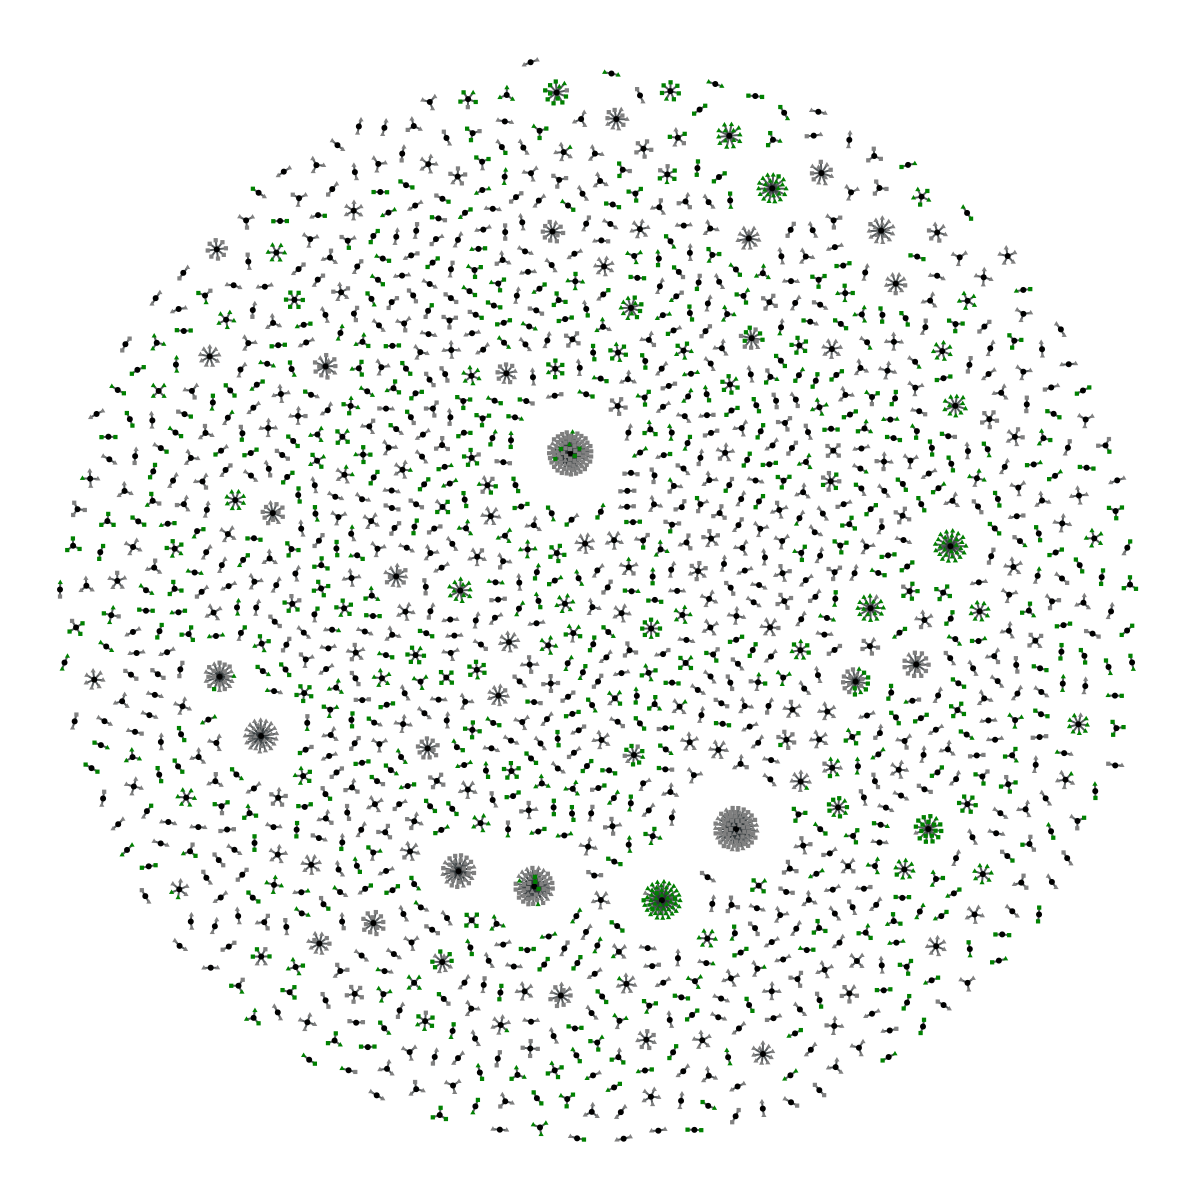

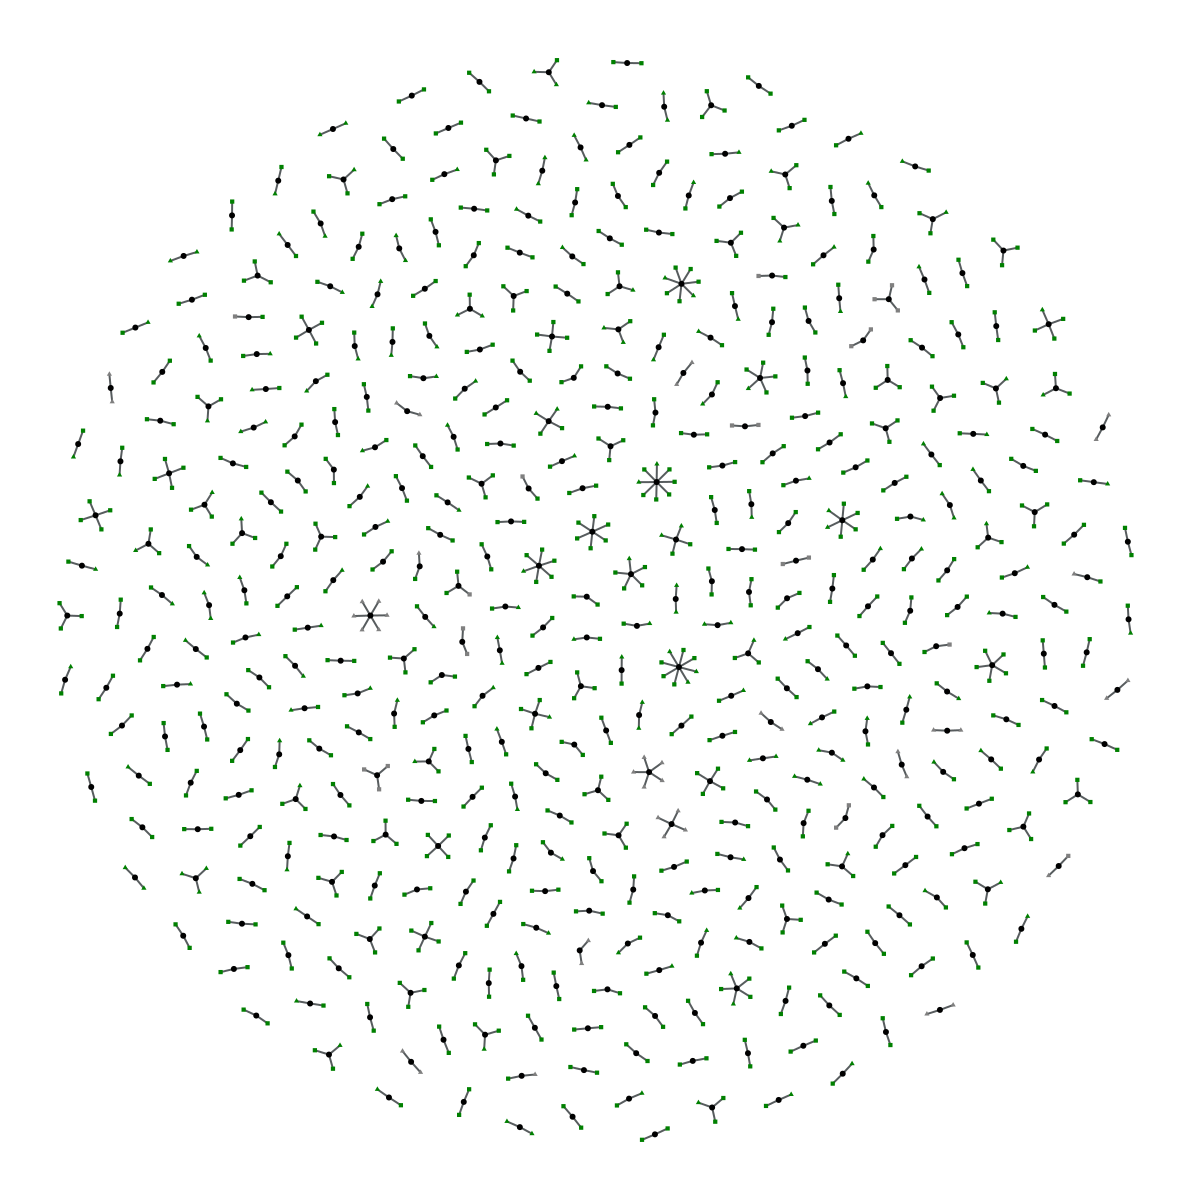

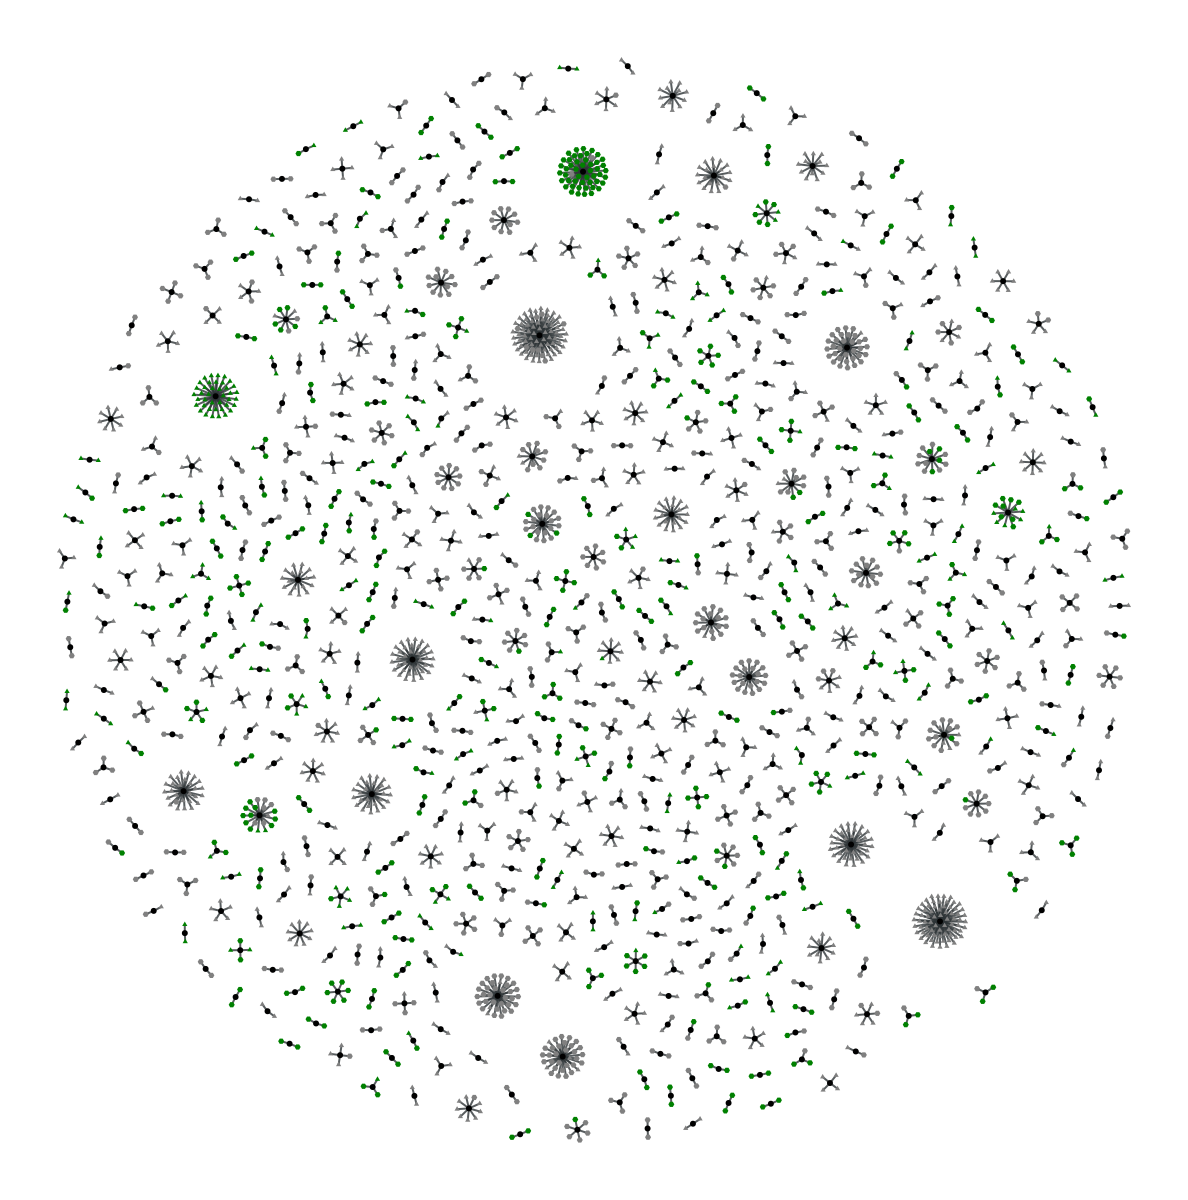

In [46]:
# add
#iterate thru donors:
for i, donor in df.groupby("donor"): 
    node_dict = df_generate_node_dict(donor)
    draw_gviz(node_dict=node_dict, size_multiple=1, layout = 'patchwork')